In [1]:
import sys
import os

sys.path.append('/import/silo2/aloe8475/Documents/edamame') #point to edamame locally
sys.path.append('/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/EquilProp') #point to edamame locally

#Choose which nw:
nwChoice=700 #350 or 700

if nwChoice == 350:
    fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00'
elif nwChoice == 700:
    fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00698_nj_02582_seed_002_avl_10.00_disp_01.00_lx_75.00_ly_75.00'

#point to network data path ^ 

saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/' 
dataLoc='/import/silo2/aloe8475/Documents/Data/Associative Learning/EquilProp/'

#import edamame (neuromorphic nanowire python package by Ruomin Zhu)
from edamame import * 
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import loadmat, savemat
import networkx as nx
from tqdm.notebook import tqdm_notebook as tqdm
from IPython.core.debugger import set_trace

import pickle 
import _pickle as cPickle
import gzip

from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph
from learning_functions import calc_cost,setupStimulus,setupSourcesOnly,runTesting,getNWState,calcOutputs


" Load Networks "
def buildNetworks(fileName,ManualSources=True,numDrains=2,numSources=9):
    #load data
    nw=loadmat(fileName)
    nwSize = nw['number_of_wires'][0][0]
    nwJunctions=nw['number_of_junctions'][0][0]
    print('Network '+str(nwSize)+ ' Loaded')
#     this_seed=8639
    Network=nw
    connectivity=connectivity__(wires_dict=Network) 

    #fixing file structure from Matlab:
    connectivity.avg_length=connectivity.avg_length[0][0]
    connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
    connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
    connectivity.dispersion=connectivity.dispersion[0][0]
    # connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
    connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
    connectivity.length_x=connectivity.length_x[0][0]
    connectivity.length_y=connectivity.length_y[0][0]
    connectivity.number_of_wires=connectivity.number_of_wires[0][0]
    connectivity.numOfWires=connectivity.numOfWires[0][0]
    connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
    connectivity.theta=connectivity.theta[0][0]
    connectivity.this_seed=connectivity.this_seed[0][0]
    
    #find x and y values of each end of each wire 
    xa=connectivity.xa[0]
    xb=connectivity.xb[0]
    ya=connectivity.ya[0]
    yb=connectivity.yb[0]

    #Pick Electrode placement/distance apart:
    
    #DRAINS
    numDrains=9
    ex=np.zeros(numDrains)*5#*15
    if nwSize > 500:
        eyVal=76
    else:
        eyVal= 51
    ey=np.linspace(-1,eyVal,numDrains)#(-1,101,numDrains)

    elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates


    #IN A LINE:
    if nwSize > 500:
        exVal=75
        eyVal = 74
    else:
        exVal=50
        eyVal=49
    ex=np.ones(numSources)*exVal#50
    ey=np.linspace(-2,eyVal,numSources)#(-2,99,numSources)
    
    #IN A 3X3 GRID:
    # middleNWx=int(connectivity.length_x/2)+1
    # middleNWy=int(connectivity.length_y/2)-1
    # distBwElecs=10
    # ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
    # ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

    elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates


    #Manual Source Placement:
    if ManualSources:
        if numSources==9:
            if nwSize > 500:
                elecSource=[678, 260, 491, 173, 628, 424, 301, 236, 483] #700nws
            else:
                elecSource=[23,320,194,74, 145, 317, 129, 34, 141] #350 nws

        elif numSources == 4:
            elecSource=[320,42,161,141]

#     elecDrain=elecDrain[[0,-1]]
    
    return connectivity,elecSource,elecDrain,nwSize,nwJunctions

#Generate 9 random 3x3 patterns:
def generatePatterns(numSamples=40):
    pattern=[]
    K = 3
    N = 9
    nback=9

    arr=np.array([1]*K + [0] * (N-K))
    for p in range(N):
        np.random.shuffle(arr)
        pattern.append(arr.copy())
    target=pattern[0]
    orig_inputs=np.array(pattern).astype('double')
    targets=[1,2,3,4,5,6,7,8,9]
    
    return orig_inputs,targets

#This function runs each training epoch and saves the network state at the last timestep of that epoch   
def getNWState_backprop(training_stimulus,train,state,drains,sources,tmpTiming,tmpTargets,limVal,allVals,run_time=2,dt=0.01,disable_tqdm=False):
    if train:
        #remove non-target drain from simulation
        target = tmpTargets[0]
        drains=drains[target-1]
        print('\nDrain '+str(target)+ ' Only')

    else:
        print('\nAll Drains')
    eles = np.append(drains, sources) #all drains
    #     if len(eles) == num_drain_training + num_source_training:
    training_sim,cost = runSim_backprop(connectivity, 
                                   stimulus = training_stimulus,
                                   junctionMode = 'tunneling',
                                   dt = dt, T = run_time, 
                                   contactMode = 'preSet',
                                   electrodes = eles,
                                   findFirst = False,
                                   start_state = state,
                                   disable_tqdm=disable_tqdm,
                                   collapse=False,tmpTiming=tmpTiming,tmpTargets=tmpTargets,
                                   limVal=limVal,allVals=allVals)  
    JS1 = getJunctionState(training_sim, -1) #save state
    #     else: 
    #         print('Bless you Joel :)')
    return training_sim,JS1   

#Combine drain voltage change with runSim:
def runSim_backprop(Connectivity, 
                    junctionMode='binary', collapse=False,
                    criticalFlux=0.1, maxFlux=1.5e-1,
                    contactMode='farthest', electrodes=None,
                    dt=1e-3, T=10, 
                    stimulus = None,
                    biasType = 'DC',
                    onTime=0, offTime=50000000,
                    onAmp=1, offAmp=0.005,
                    f = 1, customSignal = None,
                    start_state = None,
                    lite_mode = False, save_steps = 1,
                    findFirst = True,
                    disable_tqdm = False,
                    freeze_wire = None, freeze_junction = None, 
                    freeze_TimeStamp = None,tmpTiming=[],tmpTargets=[],
                    limVal=0.5,allVals=[]):

    """
    For the case of multi electrodes, stimulus should be in parameters.
    See help(stimulus__) for how to generate stimulus__ objects.
    """

    SimulationOptions = simulationOptions__(dt = dt, T = T,
                                            connectivity = Connectivity, 
                                            contactMode = contactMode,
                                            electrodes = electrodes)

    if ((contactMode == 'preSet') and (len(electrodes) > 2)) or stimulus is not None:
        from sys import exit
        if stimulus == None:
            logging.warning(f'Multiple electrodes detected. Please input stimulus in parameters!')
            exit()
        if len(stimulus) < len(SimulationOptions.electrodes):
            diff = len(SimulationOptions.electrodes) - len(stimulus)
            for _ in range(diff):
                stimulus.append(stimulus__('Drain', T = T, dt = dt))

        if len(stimulus) > len(SimulationOptions.electrodes):
            logging.warning(f'More stimulus than electrodes. Current setup has {len(SimulationOptions.electrodes)} electrodes!')
            exit()
            
        if len(stimulus[0].signal) < len(SimulationOptions.TimeVector):
            logging.warning(f'Stimulus length not correct, current time vector has length {len(SimulationOptions.TimeVector)}!')
            exit()
        SimulationOptions.stimulus = stimulus
            
    elif contactMode == 'boundary':
        SimulationOptions.stimulus[:int(len(SimulationOptions.electrodes)/2)] = [stimulus__(biasType = biasType, 
                                                                                        T = T, dt = dt,
                                                                                        onTime = onTime, offTime = offTime,
                                                                                        onAmp = onAmp, offAmp = offAmp,
                                                                                        f = f, customSignal= customSignal)
                                                                                        for i in range(int(len(SimulationOptions.electrodes)/2))]
    else:
        SimulationOptions.stimulus[0] = stimulus__(biasType = biasType, 
                                                T = T, dt = dt,
                                                onTime = onTime, offTime = offTime,
                                                onAmp = onAmp, offAmp = offAmp,
                                                    f = f, customSignal= customSignal)
    if start_state == None: 
        JunctionState = junctionState__(Connectivity.numOfJunctions, 
                                    mode = junctionMode, collapse = collapse, 
                                    criticalFlux=criticalFlux, maxFlux = maxFlux)
    else:
        from copy import deepcopy
        JunctionState = deepcopy(start_state)
    
    kwdict = dict()
    if (freeze_wire != None) or (freeze_junction != None):
        kwdict = dict(freeze_wire = freeze_wire,
                    freeze_junction = freeze_junction, 
                    freeze_TimeStamp = freeze_TimeStamp)
        
    this_realization,cost = simulateNetwork_backprop(SimulationOptions, Connectivity, JunctionState,tmpTiming,tmpTargets,limVal,allVals,lite_mode, disable_tqdm, save_steps, **kwdict)
    
    # if we stop simulation at theta, use this code. otherwise we reset voltages to 0 instead
    
#     finalIter=np.max(np.nonzero(this_realization.electrodeCurrent))
#     if finalIter < 199:
#         this_realization.electrodeCurrent=this_realization.electrodeCurrent[:finalIter+1,:]
#         this_realization.junctionVoltage=this_realization.junctionVoltage[:finalIter+1,:]
#         this_realization.junctionConductance=this_realization.junctionConductance[:finalIter+1,:]
#         this_realization.wireVoltage=this_realization.wireVoltage[:finalIter+1,:]
#         this_realization.filamentState=this_realization.filamentState[:finalIter+1,:]
#         this_realization.junctionSwitch=this_realization.junctionSwitch[:finalIter+1,:]
        #final Iter = time , use that to find / save network state
        
        
#         this_realization.TimeVector=this_realization.TimeVector[:finalIter+1,:]

    #     remove zeros from simulations that ended early:
#     this_realization.junctionCurrent
    
    if findFirst:
        from edamame.analysis.GraphTheory import findCurrent
        try:
            activation = findCurrent(this_realization, 1)
            logging.info(f'First current path {activation[0][0]} formed at time = {activation[1][0]} s.')
        except:
            logging.info('Unfortunately, no current path is formed in simulation time.')

    return this_realization,cost

def simulateNetwork_backprop(simulationOptions, connectivity, junctionState,tmpTiming,tmpTargets, limVoltage,allVals,lite_mode = False, disable_tqdm = False, save_steps = 1, **kwargs):
    niterations = simulationOptions.NumOfIterations
    electrodes = simulationOptions.electrodes
    numOfElectrodes = len(electrodes)
    E = connectivity.numOfJunctions
    V = connectivity.numOfWires
    edgeList = connectivity.edge_list
    cost      = []

#     onAmp     = simulationOptions.stimulus[3].onAmp
    
#     maxV      = onAmp *limVoltage
    
    Network = network__()
    sampling = np.arange(0, niterations, save_steps)
    if lite_mode:
        Network.connectivity = connectivity__(adjMat = connectivity.adj_matrix)
        Network.filamentState = np.zeros((int(niterations/save_steps), E))
        Network.wireVoltage = np.zeros((int(niterations/save_steps), V))
        Network.electrodeCurrent = np.zeros((int(niterations/save_steps), numOfElectrodes))
        Network.TimeVector = np.zeros(int(niterations/save_steps))
    else:        
        Network.connectivity = connectivity
        Network.TimeVector = simulationOptions.TimeVector
        Network.filamentState = np.zeros((niterations, E))
        Network.junctionVoltage = np.zeros((niterations, E))
        # Network.junctionResistance = np.zeros((niterations, E))
        Network.junctionConductance = np.zeros((niterations, E))
        Network.junctionSwitch = np.zeros((niterations, E), dtype = bool)
        Network.wireVoltage = np.zeros((niterations, V))
        Network.electrodeCurrent = np.zeros((niterations, numOfElectrodes))

    Network.sources = []
    Network.drains = []
    for i in range(numOfElectrodes):
        if np.mean(simulationOptions.stimulus[i].signal) != 0:
            Network.sources.append(electrodes[i])
        else:
            Network.drains.append(electrodes[i])

    if len(Network.drains) == 0:
        Network.drains.append(electrodes[1])
        
    if 'freeze_wire' in kwargs:
        freeze_wire = kwargs['freeze_wire']
        freeze_TimeStamp = kwargs['freeze_TimeStamp']
    else:
        freeze_TimeStamp = niterations + 1
    
    
    stopTrain=False
    for this_time in tqdm(range(niterations), desc='Running Simulation ', disable = disable_tqdm): #each time step
        if not stopTrain: #if training and reached theta or testing
            this_stimulus = np.array([i.signal[this_time] for i in simulationOptions.stimulus])
#         else:
#             break
        if tmpTiming[this_time]=='Train':
            trainTime=True
            
        elif tmpTiming[this_time]=='Test':

            trainTime=False

        if trainTime and this_time > 0 and not stopTrain: #if we are training, change drain voltages, otherwise just use this_stimulus
            
            this_stimulus[:num_drain_training]=new_stimulus

        #run sim   
        sol = simCore(connectivity, junctionState, this_stimulus, electrodes, simulationOptions.dt)

        if this_time >= freeze_TimeStamp:
            others = np.setdiff1d(range(V), freeze_wire)
            wireVoltage[others] = sol[others]
        else:
            wireVoltage = sol[0:V]

        if lite_mode:
            if this_time%save_steps == 0:
                Network.wireVoltage[this_time//save_steps,:] = wireVoltage
                Network.electrodeCurrent[this_time//save_steps,:] = sol[V:]
                Network.filamentState[this_time//save_steps,:] = junctionState.filamentState
                Network.TimeVector[this_time//save_steps] = simulationOptions.TimeVector[this_time]
        else:
            Network.wireVoltage[this_time,:] = wireVoltage
            Network.electrodeCurrent[this_time,:] = sol[V:]
            Network.filamentState[this_time,:] = junctionState.filamentState
            Network.junctionVoltage[this_time,:] = junctionState.voltage
            Network.junctionConductance[this_time,:] = junctionState.conductance
            Network.junctionSwitch[this_time,:] = junctionState.OnOrOff

        ## BackProp Implementation
        if trainTime:
            n = num_drain_training #num of drains
            y = Network.electrodeCurrent[this_time,:num_drain_training]
        else:
            n = num_drain_testing
            y = Network.electrodeCurrent[this_time,:num_drain_testing]
            
        beta      = 0.05 #learning rate
        grad      = np.zeros((n)) #set gradients to zero for each epoch  
        
        drainCurrents=y #copy of current

        if tmpTargets[this_time] != -2: #skip rest values
            tarIdx=tmpTargets[this_time]
            y = y/(maxCurrent) # normalize current

            d = 1 #allTargets[tarIdx] #define target normalized current
            if trainTime: 
                dsig = this_stimulus[:num_drain_training] #define new drain voltage
            else:
                dsig = this_stimulus[:num_drain_testing]
                
            #calc cost
            cost.append(calc_cost(y,d))

            if trainTime and not stopTrain: #if we are training, update beta
                if drainCurrents[0]>=allVals[tarIdx-1]: #if greater or less than the target current
                    this_stimulus=np.zeros(len(this_stimulus)) #make everything 0V (inputs + drains)
                    stopTrain=True
                else:
                    stopTrain=False 

                
                if not stopTrain:        
                    grad=beta*(y-d) #y = current, d = target #e.g. [y1 vs (d1 = 1), y2 vs (d2 = 0), y3vs (d3 = 0)]

                    #dsig = old voltage drains, dsig2 = new voltage drains, onAmp = input voltage

                    dsig2=np.array(dsig.T+grad)

                    dsig2=np.clip(dsig2,-onAmp*0.9,onAmp*0.9) #set max and min voltages to less than inputs

                    new_stimulus=dsig2

            elif not trainTime:
                new_stimulus=this_stimulus[:num_drain_testing]

    print('Target: 1')
#     print('Voltage: '+ str(new_stimulus))
    
    Network.numOfWires = V
    Network.numOfJunctions = E
    Network.electrodes = simulationOptions.electrodes
    if len(electrodes) <= 2:
        Network.conductance = Network.electrodeCurrent[:,1]/simulationOptions.stimulus[0].signal[sampling]
    if not lite_mode:
        Network.stimulus = [simulationOptions.stimulus[i] for i in range(numOfElectrodes)]
        Network.junctionResistance = 1/Network.junctionConductance
    
#     print(Network.electrodeCurrent[:,1])
    return Network,cost



def runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks=[],maxCurrent=[1e-5,1e-5],limVal=0.5,accThresh=0.5,increaseVal=0.5,decreaseVal=0.25,accThreshold=False,orderTraining=[]):
    """
    n-back task:
    input sample 1 with backprop, then sample 2 with backprop, then sample 1 again with reset drain voltages 
    n back here = 1, showing memory
    
    train sample x, test sample x + nback (e.g. nback = 2, sample = [s1 train,s2,s3,s1 test] )

    increase n-back: 
    sample 1 with backprop, sample 2, sample 3... test sample 1 - n=2
    
    Things to test:
    - if we increase input frequency (dt), do we see greater long term memory? (higher n-backs)
    - if we decrease frequency, do we see greater short term memory? (lower n-backs)

    """  
    
    t           = [[None]*900 for i in range(len(nbacks))]
    simVoltages = []
    saveStim    = []
    count=0
    for nback in nbacks: #how many samples to "remember" in the past before testing
       
        numTestingSamples= numSamples #how many samples across all nback values
                
        #completely random order

        orderTrainingLabelsNBACK=[1]*numSamples #these are the testing labels - every i+nback training sample is what we're testing
        orderTesting=[]
        for label in orderTrainingLabelsNBACK: #for each training label in the random order:
            orderTesting.append(-1)

        i = nback
        order=list(orderTraining).copy()
        numInserts=0
        while numInserts < numSamples:
            order.insert(i, -1)
            i += nback+1
            numInserts+=1
        
    
        #remove excess training (i.e. with no testing sample)
        sampleTimes=numDT*(nback+1)
        newTrainingOrder=orderTraining[:sampleTimes-numTestingSamples]

        order=order[:sampleTimes]        
        #RUN SIM
        numClasses          = 9
        signalType          ='DC'
        num_source_training = numSources
        tmpSources          = [[] for i in range(len(order))]
        tmpTargets          = [None]*len(order)
        sim                 = [None]*len(order)
        thresholdValues     = [None]*len(order)
        cost                = [None]*len(order)
        simVoltages         = [None]*len(order)
        accuracy    = []
        timing=[]
        allLabels=[]
        allVals=[limVal]*9
        
        i=0
        numTests = 0
        nwState = None
        for val in tqdm(order): #this method loops through samples in the randomised training order
            
            #FOR EACH SAMPLE:
            
            #are we training or testing?
            if val in orderTesting:
                test=True
                train=False
                newval=0
            elif val in orderTraining:
                test=False
                train=True
                newval=val
                print('Training \n')
                
            #define samples
            if train: #if we're training
                this_sample = inputs[newval].copy()#trainingInputs[val].copy() #xs
                this_label  = targets[newval] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmp #tune voltage based on onAmp
                timing.append('Train')

            elif test: #if we're testing
                this_sample = inputs[newval].copy() #xs
                this_label  = targets[newval] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmpTest #CHANGE THIS TO RAMP:
                timing.append('Test')

            targetTmp = signal_expand(this_label,numDT) #number of timesteps per target
            timing[i] = signal_expand(timing[i],numDT)
        #     #array of nans:
            tmpArray=np.empty(restDur)
            tmpArray[:]=-2
            targetTmp = np.append(targetTmp,tmpArray) #add rest #need to remove targets from rest
            tmpTargets[i]=targetTmp 
            rampV=np.linspace(0,onAmpTest,numDT)
            for j in range(len(this_sample)): #for each source electrode
                tmp = signal_expand(this_sample[j],numDT)
                tmp = np.append(tmp,np.zeros(restDur)) #add rest
                tmpSources[i].append(tmp)
            allLabels.append(this_label)
            stimulus=[]
            if train:
                stimulus.append(stimulus__(biasType='Drain',T=dt*len(tmpSources[i][0]),dt=dt))

            elif test:
                for m in range(num_drain_testing): #create stimulus for each drain electrode
                    stimulus.append(stimulus__(biasType='Drain',T=dt*len(tmpSources[i][m]),dt=dt))

            for m in range(len(tmpSources[i])): #create stimulus for each source electrode
                stimulus.append(stimulus__(biasType='Custom',T=dt*len(tmpSources[i][m]),dt=dt,customSignal=tmpSources[i][m]))
            
            signalLen=Tlen#len(stimulus[0].signal) 
            sim[i],nwState = getNWState_backprop(stimulus,train,nwState,drain_pool,sources,timing[i],tmpTargets[i].astype('int'),limVal,allVals,run_time=int(signalLen*dt),dt=dt,disable_tqdm=False)

            simVoltages[i]=(sim[i].wireVoltage)

            print('Currents: ' + str(sim[i].electrodeCurrent[-1][0]))
            
            if test: #if we are testing
                print('Testing \n')
                #ADRIAN ACCURACY METHOD
                t[count][i]=(calcOutputs(sim[i],sources,drain_pool))
                meanCurrAll=np.mean(t[count][i][0:],axis=1)

                if np.argmax(meanCurrAll)==0:
                    accuracy.append(1)
                else:
                    accuracy.append(0)
                        
                if i >0 and reinforcement:
                    if accuracy[numTests]==0: #if the training didn't work
                        allVals[0]=allVals[0]+increaseVal #update 'max current limit based on reinforcement'
                        allVals[1]=allVals[1]-decreaseVal
                        allVals[2]=allVals[2]-decreaseVal
                        allVals[3]=allVals[3]-decreaseVal
                        allVals[4]=allVals[4]-decreaseVal
                        allVals[5]=allVals[5]-decreaseVal
                        allVals[6]=allVals[6]-decreaseVal
                        allVals[7]=allVals[7]-decreaseVal
                        allVals[8]=allVals[8]-decreaseVal
                        
#                 #ALON ACCURACY METHOD
#                 #calucalte accuracy
#                 accThreshold=False
#                 if accThreshold:
#                     #add threshold of difference to ensure accuracy:
#                     argmaxvals=np.argmax([t[count][i][0],t[count][i][1]],axis=0)
#                     for s in range(len(argmaxvals)):
#                         if abs(t[count][i][0][s]-t[count][i][1][s])>1e-6 and argmaxvals[s]==1:
#                             argmaxvals[s]=1
#                         elif abs(t[count][i][0][s]-t[count][i][1][s])<1e-6 and argmaxvals[s] == 1:
#                             argmaxvals[s]=0
# #                     accuracy.append(np.sum(argmaxvals==tmpTargets[testTimes])/len(tmpTargets[testTimes]))
#                     accuracy.append(np.sum(argmaxvals==tmpTargets[i-nback])/len(tmpTargets[i-nback]))
#                 else:
#                     accuracy.append(np.sum(np.argmax([t[count][i][0],t[count][i][1]],axis=0)==tmpTargets[i-nback])/len(tmpTargets[i-nback]))
#                 if i >0:
#                     if accuracy[numTests]<= accThresh: #if the training didn't work
#                         if this_label==0: #drain 1
#                             limVals0=limVals0+increaseVal #update 'max current limit based on reinforcement'
#                             limVals1=limVals1-decreaseVal
#                         elif this_label==1: #drain 2
#                             limVals0=limVals0-decreaseVal
#                             limVals1=limVals1+increaseVal                           
#                 mval1=np.max(np.nonzero(t[count][i][0]))
#                 mval2=np.max(np.nonzero(t[count][i][1]))
#                 print('Final Target Drain Current: ' + str([t[count][i][0][mval1],t[count][i][1][mval2]]))

                print('Currents: ' +str(sim[i].electrodeCurrent[-1][:9]))
                print('Target: ' + str(tmpTargets[i][0]))
                print('Accuracy: '+ str(accuracy[numTests]))
                print("New Target Threshold:" + str(allVals[0])) #just a checking/debugging print
                numTests+=1
            else:
                t[count][i]=(calcOutputs(sim[i],sources,[drain_pool[int(tmpTargets[i][0])-1]]))
#             set_trace()
            thresholdValues[i]=allVals.copy()
            i+=1 
        
        count+=1
    set_trace()
    return t,thresholdValues,sim,stimulus,accuracy,tmpTargets,newTrainingOrder,orderTesting,order,testTimes,trainTimes,numTestingSamples

2022-04-28 12:42:32,251:INFO:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [ ]:
num_drain_training=1
num_drain_testing=9
numSources=9
numSamples=90
nbacks         = [9]
nback=nbacks[0]

reinforcement=True #do we want to activate reinforcement?

connectivity,sources,drain_pool,nwSize,nwJunctions=buildNetworks(fileName,True,num_drain_training,numSources)

inputs,targets=generatePatterns(numSamples)

# CHOOSE RANDOM ORDER TO PRESENT EACH SAMPLE:
seed=69
np.random.seed(seed)

orderTraining=[]
for n in range(numSamples):
    orderTraining.append(np.random.choice(9,9,replace=False))
orderTraining=np.array(orderTraining).reshape(-1)

#CHOOSE PREDETERMINED ORDER TO PRESENT EACH SAMPLE:
epochsPerSample=int(numSamples/nback)

patternSize=3

#Amplitude:
onAmp = 0.3 #Voltage for Training
onAmpTest = 0.1 #Voltage for Testing

#Time Parameters
dt=0.01
Tlen = 200
timesteps   = Tlen/dt
numDT       = 200#int(timesteps/len(inputs)) #number of timesteps per sample
restDur=0

accThreshold=False #do we want to force a minimum (arbitrary) difference between target and non-target drain for accuracy to be counted?

#Other Variables
maxCurrent = [1e-5] #target
threshCurrent = [5e-6]
numRuns        = 1
sim            = [None]*numRuns
stimuli        = [None]*numRuns
accuracy       = [None]*numRuns
# trainingOrder = [None]*numRuns
# testingOrder = [None]*numRuns
# testingLabels  = [None]*numRuns
# trainingLabels  = [None]*numRuns
testTimes      = [None]*numRuns
trainTimes      = [None]*numRuns
# targets        = [None]*numRuns
numTestingSamples = [None]*numRuns
allLabels      = [None]*numRuns
# seeds          =  np.array([4690])#np.random.choice(10000,size=numRuns,replace=False)

limValues = [threshCurrent[0]]#[1e-6]#list(np.arange(0.05,1.05,0.05))  #if we want to loop through onAmp limit voltage percentage for drains
increaseVal=threshCurrent[0]/6
decreaseVal=threshCurrent[0]/12
accThresh=0.7

loadOnly=False


if loadOnly == False:
    print('Parameters:\n')
    print('Train V: ' + str(onAmp))
    print('Test V: ' + str(onAmpTest))
    print('Pattern: ' + str(patternSize)+'x'+str(patternSize))
    meanAcc=[]
    stdAcc=[]
    outputs=[]
    for val in tqdm(limValues):
        print(val)
        for i in tqdm(range(numRuns)):
            outputs.append(runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks,maxCurrent,val,accThresh,increaseVal,decreaseVal,accThreshold=accThreshold,orderTraining=orderTraining))    

Network 698 Loaded
Parameters:

Train V: 0.3
Test V: 0.1
Pattern: 3x3


  0%|          | 0/1 [00:00<?, ?it/s]

5e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.2748044676033098e-07
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.1512620077360532e-07
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 8.575317085641202e-08
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.9209441068159373e-09
Testing 

Currents: [2.92094411e-09 1.54149685e-07 4.48376438e-07 1.35824150e-07
 3.27548967e-09 2.48423060e-07 3.99299213e-07 9.24843862e-08
 3.35264663e-09]
Target: 1.0
Accuracy: 0
New Target Threshold:5.833333333333334e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.287172016822905e-07
Testing 

Currents: [5.28717202e-07 1.38957495e-07 1.64786970e-07 1.46727148e-08
 1.24636801e-08 2.46194006e-08 3.05843738e-07 4.17838214e-08
 2.71717015e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:5.833333333333334e-06
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.078895349225898e-07
Testing 

Currents: [3.07889535e-07 1.99130780e-08 5.73174672e-08 2.03459391e-07
 9.28516755e-08 2.91090049e-07 3.11748287e-07 3.78004280e-08
 2.73656615e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:5.833333333333334e-06
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.448032022667883e-07
Testing 

Currents: [3.44803202e-07 2.80659707e-07 9.83190076e-08 3.60181523e-07
 3.55341978e-09 6.81798585e-08 2.55165289e-07 7.20546631e-08
 2.44657292e-07]
Target: 1.0
Accuracy: 0
New Target Threshold:6.6666666666666675e-06
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.6834571669429206e-07
Testing 

Currents: [3.68345717e-07 1.93052031e-08 2.68019754e-08 3.47215830e-07
 4.33291552e-09 7.81802721e-08 3.08642953e-07 8.64582922e-09
 2.87006069e-07]
Target: 1.0
Accuracy: 0
New Target Threshold:7.500000000000001e-06
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.340710460608534e-07
Testing 

Currents: [6.34071046e-07 4.17475769e-08 3.24070043e-08 5.29037382e-08
 5.58956623e-09 9.10368114e-08 4.64327446e-09 1.83231701e-07
 2.90375219e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:7.500000000000001e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.9352661462104e-07
Testing 

Currents: [2.93526615e-07 2.87400026e-08 1.77990964e-07 2.39747629e-07
 3.21961646e-09 2.20869471e-08 3.12296311e-07 6.65197840e-09
 2.51822205e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:7.500000000000001e-06
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.113530753142443e-07
Testing 

Currents: [5.11353075e-07 1.30712838e-07 1.93382041e-08 1.29928698e-08
 2.65115873e-09 6.66822864e-08 3.10226323e-07 6.89647775e-09
 2.54287231e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:7.500000000000001e-06
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.55830963941626e-07
Testing 

Currents: [3.55830964e-07 2.39958758e-08 1.05071601e-08 2.15001169e-07
 1.30390513e-08 4.44552538e-08 1.13577415e-08 9.50124280e-08
 3.48998394e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:7.500000000000001e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.3571481080104346e-07
Testing 

Currents: [3.35714811e-07 2.78625479e-07 7.35462051e-09 1.32829928e-08
 1.93853035e-08 5.64111292e-08 9.72834386e-08 1.52851060e-08
 3.33546964e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:7.500000000000001e-06
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.172299663055021e-07
Testing 

Currents: [3.17229966e-07 4.78152607e-08 2.38427740e-07 2.43301123e-08
 6.22796488e-09 5.04812530e-08 7.25749617e-09 1.11418922e-07
 3.14177532e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:7.500000000000001e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.1422283723267557e-07
Testing 

Currents: [2.14222837e-07 7.82344481e-08 1.59953071e-08 2.39653342e-07
 4.73978952e-09 3.12386001e-08 2.90094214e-07 1.18759467e-08
 2.85432288e-07]
Target: 1.0
Accuracy: 0
New Target Threshold:8.333333333333334e-06
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.70337930607884e-07
Testing 

Currents: [5.70337931e-07 1.80692942e-07 1.10157314e-08 3.22561903e-08
 1.24302699e-07 7.26130263e-08 8.83727580e-09 1.23393569e-08
 3.20514631e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:8.333333333333334e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.6621983754573745e-07
Testing 

Currents: [3.66219838e-07 1.23438731e-08 5.13643175e-08 2.64007803e-08
 4.83693583e-09 7.41357222e-09 1.70176035e-08 8.33587241e-08
 3.48614762e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:8.333333333333334e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.375272398244961e-07
Testing 

Currents: [5.37527240e-07 2.36554329e-07 3.58305156e-08 2.16555357e-08
 8.65610130e-08 1.77847349e-08 2.23306442e-08 4.81533471e-08
 4.08378005e-08]
Target: 1.0
Accuracy: 1
New Target Threshold:8.333333333333334e-06
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.117968933388766e-07
Testing 

Currents: [3.11796893e-07 1.30013344e-08 2.83936812e-07 1.68876725e-08
 2.35600932e-08 5.87925264e-08 2.15293217e-07 7.82837080e-09
 4.74093302e-09]
Target: 1.0
Accuracy: 1
New Target Threshold:8.333333333333334e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.54461323730175e-07
Testing 

Currents: [4.54461324e-07 4.19151089e-07 8.51241331e-08 3.73094794e-08
 1.54588118e-08 1.80404852e-08 2.15008465e-08 8.48198476e-08
 7.13554996e-09]
Target: 1.0
Accuracy: 1
New Target Threshold:8.333333333333334e-06
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 2.254765978081037e-07
Testing 

Currents: [2.25476598e-07 6.42627769e-08 9.81037013e-08 2.95460042e-08
 8.84496065e-09 2.21528650e-07 8.51655938e-08 7.62754040e-09
 2.22380125e-08]
Target: 1.0
Accuracy: 1
New Target Threshold:8.333333333333334e-06
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.700450196716935e-07
Testing 

Currents: [4.70045020e-07 3.75332990e-07 1.60148951e-08 1.17854287e-08
 3.47377391e-08 1.05853286e-08 6.97917473e-08 1.90944841e-08
 2.54330364e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:8.333333333333334e-06
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.8917403596626216e-07
Testing 

Currents: [3.89174036e-07 1.71338051e-08 5.76229912e-08 1.75211451e-08
 3.69012357e-09 1.06762559e-08 4.10012189e-09 1.16451609e-07
 2.43233255e-07]
Target: 1.0
Accuracy: 1
New Target Threshold:8.333333333333334e-06
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.709716411174912e-07
Testing 

Currents: [3.70971641e-07 3.28425368e-08 2.03628178e-07 3.64229840e-08
 2.45888109e-08 2.61595056e-08 8.72713821e-09 9.06574788e-09
 3.08352229e-09]
Target: 1.0
Accuracy: 1
New Target Threshold:8.333333333333334e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.7497921489905118e-07
Testing 

Currents: [1.74979215e-07 7.45476358e-09 1.03412817e-08 2.70527674e-08
 1.60717145e-07 8.33163414e-09 1.81586364e-07 2.23889027e-08
 5.87986786e-08]
Target: 1.0
Accuracy: 0
New Target Threshold:9.166666666666666e-06
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.2071986168463793e-07
Testing 

Currents: [4.20719862e-07 5.26201867e-07 1.13971059e-07 8.37487756e-08
 1.16454181e-08 1.26119291e-08 1.69321955e-07 1.14322889e-08
 2.77791252e-09]
Target: 1.0
Accuracy: 0
New Target Threshold:9.999999999999999e-06
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.909398500518891e-07
Testing 

Currents: [4.90939850e-07 2.74333432e-08 2.13206389e-09 3.49739024e-09
 2.86771641e-09 4.32238281e-08 7.72826040e-09 1.80025080e-08
 8.47688413e-08]
Target: 1.0
Accuracy: 1
New Target Threshold:9.999999999999999e-06
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.7095873491884693e-07
Testing 

Currents: [4.70958735e-07 3.74898184e-08 3.29487172e-09 1.01543194e-07
 3.40425070e-09 9.88351635e-08 3.34962520e-08 1.20163455e-08
 2.71533362e-09]
Target: 1.0
Accuracy: 1
New Target Threshold:9.999999999999999e-06
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.51518195364425e-07
Testing 

Currents: [4.51518195e-07 5.63877980e-07 1.94247512e-07 6.36057893e-08
 2.47585419e-08 1.66011146e-08 8.03532390e-09 9.89764652e-09
 1.19998855e-07]
Target: 1.0
Accuracy: 0
New Target Threshold:1.0833333333333332e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.003455574509071e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.947999040828946e-07
Testing 

Currents: [5.94799904e-07 5.23979473e-07 6.72974752e-09 8.34449096e-08
 3.88417302e-08 6.84594239e-08 2.24535672e-08 1.02174454e-08
 7.66194551e-09]
Target: 1.0
Accuracy: 1
New Target Threshold:1.0833333333333332e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0005360763933507e-05
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.8121210609378717e-07
Testing 

Currents: [3.81212106e-07 3.06677806e-07 1.40952812e-09 1.53061435e-08
 9.68287395e-08 4.06823887e-08 1.22641992e-08 5.31156734e-08
 6.38378092e-09]
Target: 1.0
Accuracy: 1
New Target Threshold:1.0833333333333332e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0016866212538443e-05
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.639582075923718e-07
Testing 

Currents: [6.63958208e-07 6.95622870e-07 1.46417332e-08 3.86729428e-08
 8.95057296e-08 1.11119165e-08 1.40110522e-08 1.13921827e-08
 7.75560117e-08]
Target: 1.0
Accuracy: 0
New Target Threshold:1.1666666666666665e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.000630319181611e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.041004863415705e-07
Testing 

Currents: [7.04100486e-07 7.41148906e-07 1.25573674e-08 1.23587988e-08
 6.22283644e-09 5.81588588e-08 8.07928563e-09 1.07763950e-08
 1.82716301e-08]
Target: 1.0
Accuracy: 0
New Target Threshold:1.2499999999999997e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0009676869724551e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.129963149691347e-07
Testing 

Currents: [7.12996315e-07 7.28298896e-07 2.42836125e-08 1.05318117e-08
 6.03172605e-09 1.35319625e-08 8.35424620e-09 8.10092211e-08
 1.04993450e-08]
Target: 1.0
Accuracy: 0
New Target Threshold:1.333333333333333e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0007557860316146e-05
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.46603956303683e-07
Testing 

Currents: [6.46603956e-07 6.82155886e-07 1.21867550e-08 1.04836019e-08
 7.45454911e-09 5.09326174e-08 4.13105558e-09 7.65924090e-09
 1.72810949e-08]
Target: 1.0
Accuracy: 0
New Target Threshold:1.4166666666666663e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0008030534573996e-05
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.469066836363951e-07
Testing 

Currents: [6.46906684e-07 6.81227802e-07 4.22045552e-08 2.10434587e-08
 5.61819758e-09 1.10083576e-08 9.34708187e-09 6.17468358e-09
 1.70528598e-09]
Target: 1.0
Accuracy: 0
New Target Threshold:1.4999999999999995e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.001444473739027e-05

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.958404241087105e-07
Testing 

Currents: [7.95840424e-07 8.46327159e-07 8.10602696e-09 1.11612119e-08
 4.34564065e-09 9.40101409e-09 1.91320539e-09 3.76692205e-09
 6.72448477e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:1.583333333333333e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0007936846336311e-05
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.74403028962957e-07
Testing 

Currents: [5.74403029e-07 6.66472533e-07 6.06607140e-09 7.03975307e-09
 3.82798976e-09 9.57991610e-09 1.93567639e-09 4.08753190e-09
 7.22523124e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:1.6666666666666664e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0010372454061859e-05
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.321593173333249e-07
Testing 

Currents: [4.32159317e-07 5.47210366e-07 4.90805910e-09 5.57958578e-09
 3.24116660e-09 9.42489865e-09 2.07595966e-09 4.48333205e-09
 7.92470026e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:1.75e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0012455815585919e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.42520116925635e-07
Testing 

Currents: [5.42520117e-07 6.51572122e-07 5.78167862e-09 6.38730935e-09
 3.61611472e-09 9.20153064e-09 1.94893309e-09 4.14899831e-09
 7.33282641e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:1.8333333333333333e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0020119710553377e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.421653775392004e-07
Testing 

Currents: [7.42165378e-07 7.78869237e-07 6.20904371e-09 7.22991088e-09
 4.11274236e-09 9.83601121e-09 1.89692910e-09 3.97467011e-09
 7.02342640e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:1.9166666666666667e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0007843318907038e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.858587321672403e-07
Testing 

Currents: [4.85858732e-07 5.73139690e-07 5.44254086e-09 6.21424806e-09
 3.50252053e-09 9.25540743e-09 2.02797270e-09 4.35425842e-09
 7.69616435e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0016971562758168e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.428134996406976e-07
Testing 

Currents: [6.42813500e-07 7.01446451e-07 6.01124398e-09 6.83160183e-09
 3.85835051e-09 9.55308166e-09 1.94368909e-09 4.11225677e-09
 7.26734449e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2.0833333333333336e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.002462303865917e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.774163276160947e-07
Testing 

Currents: [7.77416328e-07 8.16610204e-07 6.34275694e-09 7.33635801e-09
 4.16344504e-09 9.46226981e-09 1.84402331e-09 3.84143591e-09
 6.78759492e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2.166666666666667e-05
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0009263514640129e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.284136725563964e-07
Testing 

Currents: [6.28413673e-07 6.81142285e-07 6.04470759e-09 6.98125100e-09
 3.92488749e-09 9.64465771e-09 1.95630829e-09 4.13653113e-09
 7.31013537e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2.2500000000000005e-05
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0013224542077202e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.327291554845089e-07
Testing 

Currents: [6.32729155e-07 6.87477547e-07 6.05791253e-09 6.95532301e-09
 3.90404966e-09 9.60165371e-09 1.95513552e-09 4.13673225e-09
 7.31056673e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2.333333333333334e-05
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0016636630347979e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.924426184079275e-07
Testing 

Currents: [6.92442618e-07 7.47433127e-07 6.13532282e-09 7.08811438e-09
 4.00986260e-09 9.72563930e-09 1.93305832e-09 4.07018482e-09
 7.19253390e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2.4166666666666674e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0015427570280481e-05
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.344326678097311e-07
Testing 

Currents: [6.34432668e-07 6.88671604e-07 6.05124326e-09 6.94508269e-09
 3.89696239e-09 9.58030131e-09 1.95695466e-09 4.14170600e-09
 7.31934907e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2.5000000000000008e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0013038643504997e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.864292326596361e-07
Testing 

Currents: [5.86429233e-07 6.29636513e-07 5.76572523e-09 6.69252365e-09
 3.73768642e-09 9.49004401e-09 2.00880362e-09 4.28600264e-09
 7.57496993e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2.5833333333333342e-05
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0017097594860622e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 3.6437028500089066e-07
Testing 

Currents: [3.64370285e-07 4.26482827e-07 4.10115534e-09 4.89379751e-09
 2.83170510e-09 9.06077367e-09 2.23087416e-09 4.90953590e-09
 8.67954789e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2.6666666666666677e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0041085857162521e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.947532390463566e-07
Testing 

Currents: [6.94753239e-07 7.54957938e-07 6.10653430e-09 7.06201380e-09
 3.99656889e-09 9.78546890e-09 1.93218162e-09 4.07233428e-09
 7.19645078e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2.750000000000001e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0033936243094484e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.393495462508977e-07
Testing 

Currents: [7.39349546e-07 7.87973899e-07 6.22081483e-09 7.29731404e-09
 4.14304807e-09 9.78062080e-09 1.91329268e-09 4.00728415e-09
 7.08091888e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2.8333333333333346e-05
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0004146874592066e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.7345627552377436e-07
Testing 

Currents: [4.73456276e-07 5.04587630e-07 4.38464469e-09 5.18451762e-09
 2.93659578e-09 8.87403367e-09 2.20782720e-09 4.84826364e-09
 8.57110071e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:2.916666666666668e-05
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0017326584113962e-05
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.2102644806510834e-07
Testing 

Currents: [4.21026448e-07 4.49780381e-07 4.21062143e-09 4.99333952e-09
 2.84153727e-09 8.93471008e-09 2.24201524e-09 4.92151355e-09
 8.70030829e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.0000000000000014e-05
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0034574310432301e-05
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.245862028425427e-07
Testing 

Currents: [6.24586203e-07 7.03145863e-07 5.99246383e-09 6.61446337e-09
 3.67406475e-09 9.05207199e-09 1.95098850e-09 4.14822911e-09
 7.33132840e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.083333333333335e-05
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0030251455261775e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.54271274640017e-07
Testing 

Currents: [6.54271275e-07 7.26957575e-07 6.04298685e-09 6.83171221e-09
 3.83273178e-09 9.31301546e-09 1.94793841e-09 4.12216403e-09
 7.28482767e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.166666666666668e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.004376603610569e-05

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 8.348449360319382e-07
Testing 

Currents: [8.34844936e-07 8.58440450e-07 6.35794457e-09 7.43833648e-09
 4.24482495e-09 9.20858149e-09 1.80616464e-09 3.73207904e-09
 6.59365261e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.250000000000001e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0006020662599966e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.126569242064968e-07
Testing 

Currents: [6.12656924e-07 6.83754167e-07 5.96485811e-09 6.59089425e-09
 3.63228334e-09 8.83393111e-09 1.95736476e-09 4.17242692e-09
 7.37431797e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.333333333333334e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0045014346499432e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.835023705157581e-07
Testing 

Currents: [7.83502371e-07 8.18425151e-07 6.24186739e-09 7.38574406e-09
 4.20903744e-09 9.70731941e-09 1.88101629e-09 3.92241205e-09
 6.93061304e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.416666666666667e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.002342103324006e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.945478746972208e-07
Testing 

Currents: [6.94547875e-07 7.59855559e-07 6.13326545e-09 7.13899495e-09
 4.02919887e-09 9.62251787e-09 1.93710956e-09 4.07640374e-09
 7.20345007e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.5000000000000004e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0009122401748676e-05
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.183705115375551e-07
Testing 

Currents: [5.18370512e-07 5.62104004e-07 5.17612818e-09 5.93792977e-09
 3.28752766e-09 8.79560487e-09 2.08366278e-09 4.51692151e-09
 7.98441355e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.5833333333333335e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.00443916768827e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.923429096098859e-07
Testing 

Currents: [6.92342910e-07 7.61921308e-07 6.11254146e-09 7.03489152e-09
 3.96221438e-09 9.57129860e-09 1.93850988e-09 4.09009409e-09
 7.22790722e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.6666666666666666e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0024857543143035e-05
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.490299345234977e-07
Testing 

Currents: [6.49029935e-07 7.30385239e-07 6.08212385e-09 6.89478729e-09
 3.85582853e-09 9.29485385e-09 1.94838319e-09 4.12437336e-09
 7.28876776e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.75e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0036993690085506e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.425745184790309e-07
Testing 

Currents: [7.42574518e-07 7.94119759e-07 6.20000345e-09 7.28706736e-09
 4.12756754e-09 9.71960416e-09 1.92342031e-09 4.03370097e-09
 7.12768790e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.833333333333333e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0035218119236334e-05
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 8.042040706471599e-07
Testing 

Currents: [8.04204071e-07 8.23943085e-07 6.27000173e-09 7.43414442e-09
 4.22599617e-09 9.58912544e-09 1.88312040e-09 3.92397184e-09
 6.93325786e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.916666666666666e-05
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0003916126411744e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.20612886359209e-07
Testing 

Currents: [5.20612886e-07 5.80979506e-07 4.80843195e-09 5.41590588e-09
 3.02960873e-09 8.50667818e-09 2.12884990e-09 4.65076494e-09
 8.22166769e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:3.999999999999999e-05
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0023827415088771e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 4.629539229803965e-07
Testing 

Currents: [4.62953923e-07 5.09880812e-07 4.23086161e-09 4.90287250e-09
 2.80535059e-09 8.76656286e-09 2.23793728e-09 4.92495184e-09
 8.70674926e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.083333333333332e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0059962026081528e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.689765549005304e-07
Testing 

Currents: [7.68976555e-07 8.01687959e-07 6.13785369e-09 7.29567477e-09
 4.17089607e-09 9.80918523e-09 1.89874004e-09 3.95329765e-09
 6.98490228e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.166666666666665e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0030527721552379e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.061497690003616e-07
Testing 

Currents: [7.06149769e-07 7.68927230e-07 6.15044901e-09 7.15263190e-09
 4.03610058e-09 9.65298210e-09 1.93778754e-09 4.07566521e-09
 7.20210541e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.249999999999998e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.001260942823289e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.22302482374718e-07
Testing 

Currents: [5.22302482e-07 6.57156082e-07 5.68178190e-09 6.05699246e-09
 3.35777026e-09 8.40841047e-09 1.96209738e-09 4.21087749e-09
 7.44288667e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.3333333333333314e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0037099691552064e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.230081622044133e-07
Testing 

Currents: [6.23008162e-07 7.21652019e-07 5.99661837e-09 6.53982495e-09
 3.62726831e-09 8.76427708e-09 1.94716385e-09 4.14551086e-09
 7.32666137e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.4166666666666645e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0032351130325563e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.185609278478001e-07
Testing 

Currents: [6.18560928e-07 7.20845408e-07 5.99026936e-09 6.55583117e-09
 3.64445235e-09 8.80057416e-09 1.94741159e-09 4.14326306e-09
 7.32262033e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.4999999999999976e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0020746307300883e-05
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.027956934091343e-07
Testing 

Currents: [5.02795693e-07 6.07837918e-07 4.88297142e-09 5.39587896e-09
 3.07054247e-09 8.52319430e-09 2.08792762e-09 4.53978115e-09
 8.02508489e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.583333333333331e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0058264244495028e-05

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 8.121835967704106e-07
Testing 

Currents: [8.12183597e-07 8.27796884e-07 6.09883807e-09 7.31172311e-09
 4.20108545e-09 9.40197007e-09 1.84048385e-09 3.81637763e-09
 6.74273541e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.666666666666664e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0008287289703804e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.851835117847293e-07
Testing 

Currents: [5.85183512e-07 7.12113931e-07 5.88540318e-09 6.24917407e-09
 3.44192128e-09 8.32984214e-09 1.94381416e-09 4.15677417e-09
 7.34699066e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.749999999999997e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0028300291245889e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.327368833301507e-07
Testing 

Currents: [5.32736883e-07 6.68309002e-07 5.64806270e-09 5.95235476e-09
 3.29612853e-09 8.12746369e-09 1.96326475e-09 4.21621266e-09
 7.45234033e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.83333333333333e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0048332653719064e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.990655412939864e-07
Testing 

Currents: [6.99065541e-07 7.58536387e-07 6.10139565e-09 6.93811005e-09
 3.89051837e-09 9.26522800e-09 1.94142584e-09 4.10197654e-09
 7.24900634e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.916666666666663e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0016676274094213e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.350650599819974e-07
Testing 

Currents: [5.35065060e-07 6.83997759e-07 5.79401559e-09 6.09169903e-09
 3.37185819e-09 8.23537457e-09 1.94087970e-09 4.15539366e-09
 7.34465973e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:4.999999999999996e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.003975472850004e-05
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.024779492078801e-07
Testing 

Currents: [6.02477949e-07 7.20931257e-07 5.95559894e-09 6.46090847e-09
 3.59556666e-09 8.68393359e-09 1.94828799e-09 4.14884440e-09
 7.33257657e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:5.083333333333329e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.002241232824707e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.102624187814878e-07
Testing 

Currents: [5.10262419e-07 6.45527138e-07 5.46322821e-09 5.82993269e-09
 3.25189863e-09 8.29033744e-09 1.99135540e-09 4.28951337e-09
 7.58211166e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:5.1666666666666624e-05
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0043346485949178e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 6.271742760398071e-07
Testing 

Currents: [6.27174276e-07 7.31203869e-07 6.02311649e-09 6.72027573e-09
 3.76053228e-09 9.03936277e-09 1.94596566e-09 4.12616858e-09
 7.29210413e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:5.2499999999999955e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0045901848313159e-05
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.879692247073982e-07
Testing 

Currents: [7.87969225e-07 8.05806169e-07 6.18938425e-09 7.36675273e-09
 4.19817871e-09 9.61974749e-09 1.89543730e-09 3.95476096e-09
 6.98776172e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:5.3333333333333286e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.000950902412696e-05
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 5.427963264161732e-07
Testing 

Currents: [5.42796326e-07 6.88353237e-07 5.82605667e-09 6.21138620e-09
 3.42394229e-09 8.39475477e-09 1.94562600e-09 4.16522489e-09
 7.36203921e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:5.416666666666662e-05
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0050897513427954e-05
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.77027085990166e-07
Testing 

Currents: [7.77027086e-07 7.98606964e-07 6.10288134e-09 7.24966001e-09
 4.12956683e-09 9.55906090e-09 1.90183267e-09 3.97870004e-09
 7.03028969e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:5.499999999999995e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0039661586179027e-05

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 8.386525604378358e-07
Testing 

Currents: [8.38652560e-07 8.37894155e-07 6.18760189e-09 7.40858744e-09
 4.24771142e-09 9.24435313e-09 1.84030344e-09 3.81059733e-09
 6.73241994e-10]
Target: 1.0
Accuracy: 1
New Target Threshold:5.499999999999995e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0023920259814557e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.507035962890307e-07
Testing 

Currents: [7.50703596e-07 7.93837290e-07 6.20640439e-09 7.33933196e-09
 4.16011318e-09 9.66982902e-09 1.91580592e-09 4.01055707e-09
 7.08670896e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:5.583333333333328e-05
Training 


Drain 3 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 4 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 2 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 6 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 7 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 1 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 1.0027323067641298e-05
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 9 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0

All Drains


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 7.477161776235138e-07
Testing 

Currents: [7.47716178e-07 7.90853816e-07 6.20155585e-09 7.31503298e-09
 4.13913008e-09 9.68683094e-09 1.91802798e-09 4.02035314e-09
 7.10414916e-10]
Target: 1.0
Accuracy: 0
New Target Threshold:5.666666666666661e-05
Training 


Drain 5 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target: 1
Currents: 0.0
Training 


Drain 8 Only


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

In [229]:
#SAVE SIM DATA
saveName='698nw_2582nj_working_memory_nback_noReinforcement_sim'

#SAVE EACH SIM INDIVIDUALLY
for i in range(len(outputs[0][2])):
    with open(dataLoc+'/Sim Results/working memory nback/'+saveName+str(i)+'.pkl', 'wb') as f:
        pickle.dump(outputs[0][2][i], f) 

In [230]:
dataNoSim=[outputs[0][0],outputs[0][1],outputs[0][3],outputs[0][4],outputs[0][5],outputs[0][6],outputs[0][7],outputs[0][8],outputs[0][9],outputs[0][10],outputs[0][11]]

In [231]:
#SAVE ALL NONSIM DATA
saveName='698nw_2582nj_working_memory_nback_noReinforcement_data'

#SAVE ALL OTHER DATA TOGETHER
with open(dataLoc+'/Sim Results/working memory nback/'+saveName+'.pkl', 'wb') as f:
        pickle.dump(dataNoSim, f) 

In [245]:
#LOAD ALL NONSIM DATA
saveName='698nw_2582nj_working_memory_nback_wReinforcement_data'

#LOAD ALL OTHER DATA TOGETHER
with open(dataLoc+'/Sim Results/working memory nback/'+saveName+'.pkl', 'rb') as f:
        dataNoSim = pickle.load(f) 

In [246]:
#LOAD SIM DATA
saveName='698nw_2582nj_working_memory_nback_wReinforcement_sim'

#LOAD EACH SIM INDIVIDUALLY
for i in tqdm(range(len(outputs[0][2]))):
    with open(dataLoc+'/Sim Results/working memory nback/'+saveName+str(i)+'.pkl', 'rb') as f:
        sims = pickle.load(f)

  0%|          | 0/900 [00:00<?, ?it/s]

In [ ]:
# #CHOOSE PREDETERMINED ORDER TO PRESENT EACH SAMPLE:
# seed=69
# np.random.seed(seed)

# orderTraining=[]
# for n in range(numSamples):
#     orderTraining.append(np.random.choice(9,9,replace=False))
# orderTraining=np.array(orderTraining).reshape(-1)

# epochsPerSample=int(numSamples/nback)
# newOrderTrain=orderTraining.reshape(90,9)
# val=[]
# for order in newOrderTrain:
#     val.append(np.where(order==0))

(array([ 9., 11.,  8., 10., 10., 11., 10., 12.,  9.]),
 array([0.        , 0.88888889, 1.77777778, 2.66666667, 3.55555556,
        4.44444444, 5.33333333, 6.22222222, 7.11111111, 8.        ]),
 <BarContainer object of 9 artists>)

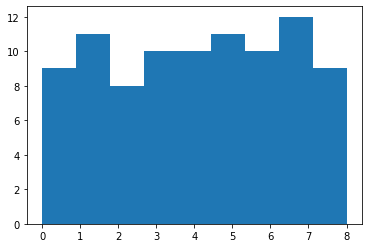

In [152]:
# plt.hist(np.where(newOrderTrain==0)[1],bins=9)

In [232]:
accuracy=outputs[0][4]

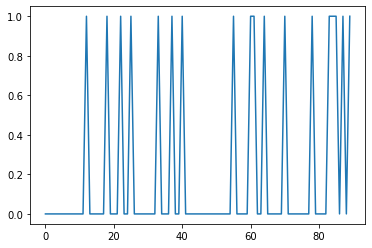

In [233]:
plt.plot(accuracy)

In [234]:
nbackVals=np.argwhere(np.array(outputs[0][8])==-1)-np.argwhere(np.array(outputs[0][8])==0)

In [235]:
nbackVals=nbackVals.reshape(-1)

In [236]:
import pandas as pd
nbackAcc=pd.DataFrame({'nback':nbackVals,'Accuracy':accuracy})

In [237]:
numVals=[]
seAcc=[]
meanAcc=[]
for i in range(1,10):
    
    numVals.append((nbackAcc.where(nbackAcc['nback']==i)).count()[0])

    meanAcc.append((nbackAcc.where(nbackAcc['nback']==i)).mean(skipna=True)[1])
    seAcc.append((nbackAcc.where(nbackAcc['nback']==i)).std(skipna=True)[1]/np.sqrt(len(nbackAcc.where(nbackAcc['nback']==i))))

In [238]:
stdAcc

[]

In [239]:
numVals

[9, 12, 10, 11, 10, 10, 8, 11, 9]

In [240]:
meanAcc

[0.6666666666666666,
 0.6666666666666666,
 0.3,
 0.09090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [241]:
nbacks=[1,2,3,4,5,6,7,8,9]

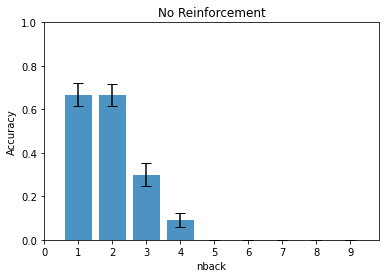

In [244]:
plt.bar(nbacks,meanAcc,yerr=seAcc,alpha=0.8, ecolor='black', capsize=5)
plt.xlabel('nback')
plt.ylabel('Accuracy')
ax=plt.gca()
ax.set_xticks(range(10))
ax.set_xticklabels(range(10))
ax.set_ylim([0,1])
plt.title('No Reinforcement')
plt.savefig(saveFig+'698nw_2582nj_nback_working_memory_no_reinforcement.png',format='png')
